<a href="https://colab.research.google.com/github/tintenderete/TFM-Algoritmo-con-redes-evolutivas/blob/main/TFM__TABULAR_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTS

In [1]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.layers import Dense, Flatten, Activation, Dropout, Reshape, Conv1D, Masking, LSTM, Conv2D, Input,Multiply, Lambda
from keras.optimizers import Adam
from keras.regularizers import L2, L1L2, L1
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, concatenate, Conv1D, Flatten
from keras.models import Model
import numpy as np
import networkx as nx
from keras.utils import plot_model
from keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
import random
import numpy as np
import keras
from tensorflow.keras.layers import Dense, Dropout, Flatten, SpatialDropout1D, BatchNormalization, Concatenate
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.callbacks import EarlyStopping
import time
from keras import backend as K
import tensorflow as tf
from google.colab import files
import matplotlib.pyplot as plt
import keras
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import tensorflow as tf
from datetime import date, timedelta
from sklearn.model_selection import train_test_split

# DATOS

NUESTRA ETIQUETA ES UNA CLASIFICACION DE SI EL ACTIVO SE ENCUENTRA O NO EN EL TOP 10 (EN FUNCION DE SU RATIO DE SHARPE) DE ACTIVOS DEL INDICE.

NUESTRO OBJETIVO NO ES PUNTUAR A LOS ACTIVOS DADO QUE LUEGO REALIZAREMOS LA ASIGNACIÓN DE PESOS A TRAVÉS DE MARKOWITZ.

NUESTRO OBJETIVO ES SELECCIONAR ACTIVOS DEL TOTAL DE ACTIVOS QUE SE ENCUENTRAN EN EL INDICE.


Una vez entrenada la red, seleccionaremos los 10 activos que tengan mas probabilidad de estar entre los 10 primeros.

## misDatos (class)

In [2]:
class misDatos():
  def __init__(self, dataset = "categorical_dataset", fecha_corte = '2021-01-01'):

    # Leer el archivo Parquet en un dataframe de pandas
    table = pq.read_table(dataset)
    df = table.to_pandas()

    #self.df_ordenado = df.sort_values(by='date')

    self.df_train = df[df['date'] <= fecha_corte]
    self.df_test = df[df['date'] > fecha_corte]

    self.df_y_train = self.df_train.iloc[:,-1]
    self.df_x_train = self.df_train.iloc[:,2:-1]

    self.df_y_test = self.df_test.iloc[:,-1]
    self.df_x_test = self.df_test.iloc[:,2:-1]

    self.scaler = StandardScaler()

    self.X_train= self.scaler.fit_transform(self.df_x_train)
    self.X_test = self.scaler.transform(self.df_x_test)

    self.Y_train = np.array(self.df_y_train)
    self.Y_test = np.array(self.df_y_test)


# REGLAS EVOLUTIVO

##  create_model (class)

Por temas de coste computacional se reduce el numero de neuronas posibles, los resultados aumentandolas son similares, y ademas los modelos tienden a sobre aprender

In [3]:
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [4]:
class create_model():

  def __init__(self):

    self.neurones_range = [1,2,3,4,5]
    self.l2_range = [0,0.3,0.6,0.9]
    self.dropout_range = [0,0.3,0.6,0.9]
    self.model_location = [0,1,2,3,4,5] # si no hay modelo a introducir dejar el array asi : [-1]

    self.model_file_name = 'best_model_0.h5'


    self.gen_dic = {
          "neurones_range_0":self.neurones_range,
          "neurones_range_1":self.neurones_range,
          "neurones_range_2":self.neurones_range,
          "neurones_range_3":self.neurones_range,
          "neurones_range_4":self.neurones_range,
          "neurones_range_5":self.neurones_range,

          "l2_range_0":self.l2_range,
          "l2_range_1":self.l2_range,
          "l2_range_2":self.l2_range,
          "l2_range_3":self.l2_range,
          "l2_range_4":self.l2_range,
          "l2_range_5":self.l2_range,

          "dropout_range_0":self.dropout_range,
          "dropout_range_1":self.dropout_range,
          "dropout_range_2":self.dropout_range,
          "dropout_range_3":self.dropout_range,
          "dropout_range_4":self.dropout_range,
          "dropout_range_5":self.dropout_range,

          "model_location": self.model_location

    }
  # METODOS PARA CREAR LOS INDIVIDUOS
  def crear_fila_conexiones(self, n):
    num_ones = np.random.randint(1, n + 1)
    array = np.array([1]*num_ones + [0]*(n-num_ones))
    np.random.shuffle(array)
    return array


  def crear_fila_conexiones_0(self, n):
    num_ones = np.random.randint(0, n+1)
    array = np.array([1]*num_ones + [0]*(n-num_ones))
    np.random.shuffle(array)
    return array

  def crear_individuo(self):

    neurones_range = self.neurones_range
    l2_range = self.l2_range
    dropout_range = self.dropout_range
    model_location = self.model_location

    ind = np.concatenate((
      self.crear_fila_conexiones(5) ,
      self.crear_fila_conexiones_0(4),
      self.crear_fila_conexiones_0(3),
      self.crear_fila_conexiones_0(2),
      self.crear_fila_conexiones_0(1),

      np.random.choice(neurones_range, size=1),
      np.random.choice(neurones_range, size=1),
      np.random.choice(neurones_range, size=1),
      np.random.choice(neurones_range, size=1),
      np.random.choice(neurones_range, size=1),
      np.random.choice(neurones_range, size=1),

      np.random.choice(l2_range, size=1),
      np.random.choice(l2_range, size=1),
      np.random.choice(l2_range, size=1),
      np.random.choice(l2_range, size=1),
      np.random.choice(l2_range, size=1),
      np.random.choice(l2_range, size=1),

      np.random.choice(dropout_range, size=1),
      np.random.choice(dropout_range, size=1),
      np.random.choice(dropout_range, size=1),
      np.random.choice(dropout_range, size=1),
      np.random.choice(dropout_range, size=1),
      np.random.choice(dropout_range, size=1),

      np.random.choice(model_location, size=1)


    ))

    return ind

  def crear_population(self, n):
    return np.array([self.crear_individuo() for _ in range(n)])

  def crear_matrix(self, individuo_matrix_genes):
    matrix = [
        np.concatenate((  np.array([0]) ,         individuo_matrix_genes[0:5] )),
        np.concatenate((  np.array([0,0]) ,       individuo_matrix_genes[5:9]  )),
        np.concatenate((  np.array([0,0,0]) ,     individuo_matrix_genes[9:12] )),
        np.concatenate((  np.array([0,0,0,0]) ,   individuo_matrix_genes[12:14]  )),
        np.concatenate((  np.array([0,0,0,0,0]) , individuo_matrix_genes[14:15]  )),
        np.array([0,0,0,0,0,0]),
    ]
    return matrix


  # METODOS PARA CREAR MODELO


  def create_layer_model(self, node, new_input, trainable = False ):

    trained_model = load_model(self.model_file_name)

    for layer in trained_model.layers:
      layer.trainable = trainable

    m = Dense(12 , activation='relu' , kernel_initializer='he_normal', name = "EntradaModeloEntrenado_"+ str(node))(new_input)
    m = trained_model(m)

    return m



  def output_layer(self, node_outputs, output_shape, activation='sigmoid' ):

    m = Flatten()(list(node_outputs.values())[-1])
    # Crear ultima capa densa para el modelo
    node_output = Dense(1, activation=activation, kernel_initializer='he_normal', name="OUTPUT"  )(m)
    # Almacenar la salida


    return node_output

  def normal_layer(self, node, node_input, n_neurons, l2, do):
    if l2 == 0 :  m = Dense(n_neurons, activation='relu'                            , kernel_initializer='he_normal', name="Densa_" + str(node) )(node_input)
    if l2 > 0 :   m = Dense(n_neurons, activation='relu', kernel_regularizer=L2(l2) , kernel_initializer='he_normal', name="Densa_" + str(node) )(node_input)
    if do > 0 :   m = Dropout(do)(m)
    return m

  def create_model_from_graph(self, matrix, gen_neurons_array, gen_l2_array, gen_dropout_array ,gen_model_location ,input_shape, output_shape):

    graph = nx.from_numpy_array(np.array(matrix), create_using=nx.DiGraph)

    # Crear una capa de entrada para el modelo
    input_layer = Input(shape=input_shape, name="INPUT")

    # Crear un diccionario para almacenar las salidas de las capas para cada nodo
    node_outputs = {}
    disconnected_nodes = set()  # para almacenar nodos desconectados

    # CONFIGURACION RED INTERNA

    # Procesar los nodos en orden topológico
    for node in nx.topological_sort(graph):
        node_input = None

        if (graph.in_degree(node) == 0) and (len(node_outputs) == 0) :
            # El primer nodo tiene el input como entrada , OBLIGATORIO, es el priemro de todos y nunca tiene "padre"
            node_input = input_layer
        elif (graph.in_degree(node) == 0) and (node != 0 ):
            # Si el nodo no tiene predecesores, su entrada es la capa de entrada del modelo
            disconnected_nodes.add(node)
            #print("nodo desconectado")
            continue

        else:
            len_aux =  len([node_outputs[predecessor] for predecessor in graph.predecessors(node) if predecessor not in disconnected_nodes])
            # Todos sus predecesores estan desconectados
            if(len_aux == 0):
              disconnected_nodes.add(node)

              continue

            # Si el nodo tiene predecesores, su entrada es la concatenación de las salidas de sus predecesores

            if len([node_outputs[predecessor] for predecessor in graph.predecessors(node) if predecessor not in disconnected_nodes]) > 1:
              node_input = concatenate([node_outputs[predecessor] for predecessor in graph.predecessors(node) if predecessor not in disconnected_nodes])
            else:

              node_input = [node_outputs[predecessor] for predecessor in graph.predecessors(node) if predecessor not in disconnected_nodes][0]


        if node == gen_model_location:
          # Añadir modelo como capa
          node_output = self.create_layer_model(node, node_input)
        else:
           # Crear una capa densa para el nodo
          node_output = self.normal_layer(node, node_input, gen_neurons_array[node], gen_l2_array[node], gen_dropout_array[node])

        # Almacenar la salida de la capa para este nodo
        node_outputs[node] = node_output


    # CONFIGURACION PARA SALIDA

    model_output = self.output_layer(node_outputs, output_shape, activation='sigmoid' )
    # Crear el modelo de Keras
    model = Model(inputs=input_layer, outputs=model_output)


    model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

    return model


  def create_model(self, indv, X_shape, Y_shape):

    indv_matrix = self.crear_matrix(indv)

    indv_model = self.create_model_from_graph(indv_matrix, indv[15:21], indv[21:27], indv[27:33], indv[-1]  , X_shape, Y_shape)

    return indv_model

##  evo_rules (class)

In [5]:
class evo_rules():
  def __init__(self, create_model):
    self.this_ = self
    self.create_model = create_model

  def crear_conjuntos(self, x, y):
    x = x
    y = y

    # Divide los datos en dos conjuntos: 66% y 34%
    x_temp, x_third, y_temp, y_third = train_test_split(x, y, test_size=0.34, random_state=42)

    # Divide el conjunto x_temp nuevamente para obtener dos conjuntos del 33% c/u.
    x_first, x_second, y_first, y_second = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

    return x_first, y_first, x_second, y_second, x_third, y_third


  def fitness_function_split(self,population, X_TRAIN,  Y_TRAIN, epochs, patience = 50,  verbose = 0 ):

    #x_first, y_first, x_second, y_second, x_third, y_third = self.crear_conjuntos(X_TRAIN, Y_TRAIN)

    h_fitness = np.empty(population.shape[0])
    h_layers = np.empty(population.shape[0])
    h_params = np.empty(population.shape[0])


    for i in range(population.shape[0]):

      fitness_1, h_layers_1, h_params_1 = self.fitness_function(np.array([population[i]]), X_TRAIN,  Y_TRAIN, epochs, patience ,  verbose  )
      fitness_2, h_layers_2, h_params_2 = self.fitness_function(np.array([population[i]]), X_TRAIN,  Y_TRAIN, epochs, patience ,  verbose  )
      fitness_3, h_layers_3, h_params_3 = self.fitness_function(np.array([population[i]]), X_TRAIN,  Y_TRAIN, epochs, patience ,  verbose  )
      fitness_4, h_layers_4, h_params_4 = self.fitness_function(np.array([population[i]]), X_TRAIN,  Y_TRAIN, epochs, patience ,  verbose  )

      h_fitness[i] = ( fitness_1 + fitness_2 + fitness_3 + fitness_4  ) / 4
      h_layers[i] = ( h_layers_1 + h_layers_2 + h_layers_3 + h_layers_4  ) / 4
      h_params[i] = ( h_params_1 + h_params_2 + h_params_3 + h_params_4  ) / 4

    return h_fitness , h_layers , h_params


  def fitness_function(self,population, X_TRAIN,  Y_TRAIN, epochs, patience = 50,  verbose = 0 ):

    h_layers =      np.empty(population.shape[0])
    h_params =      np.empty(population.shape[0])
    val_loss_win =  np.empty(population.shape[0])
    val_accuracy =  np.empty(population.shape[0])

    for i in range(population.shape[0]):

          model = self.create_model(population[i],  X_TRAIN.shape[1:], 1 )

          # Define el callback EarlyStopping
          early_stopping = EarlyStopping(monitor='val_accuracy', patience = patience, verbose=verbose, restore_best_weights=True)

          history = model.fit(X_TRAIN, Y_TRAIN,
                              epochs=epochs,
                              batch_size=X_TRAIN.shape[0],
                              validation_split= 0.3,
                              shuffle = True,
                              verbose=verbose,
                              callbacks=[early_stopping])


          vlw = ( history.history['val_loss'][-1] < history.history['loss'][-1] )  * 1
          va = max(history.history['val_accuracy'])
          #print("vlw ", vlw)
          #print("va ",va)

          val_loss_win[i] = vlw
          val_accuracy[i] = va

          h_layers[i] = len(model.layers)
          h_params[i] = sum([layer.count_params() for layer in model.layers if layer.trainable])




    return val_loss_win * val_accuracy, h_layers, h_params

  def uniform_crossover(self, parents, chance_flip = 0.5):
        print("-------------------------------")
        print(parents)
        def uniform_crossover(parent1, parent2):
            child1, child2 = parent1.copy(), parent2.copy()
            for i in range(len(parent1)):
                if np.random.uniform(0, 1) < chance_flip:  # Choose randomly
                    child1[i], child2[i] = child2[i], child1[i]  # Swap elements
            return child1, child2

        def easy_crossover(parents):
            parents = parents
            np.random.shuffle(parents)
            offspring = []
            for i in range(0, len(parents), 2):

                parent1 = parents[i]
                parent2 = parents[i+1]

                childs = uniform_crossover(parent1, parent2 )

                offspring.append(childs[0])
                offspring.append(childs[1])

            return offspring

        return np.array(easy_crossover(parents))

  def mutation(self, immigration ,offspring, chance_flip = 0.05):

        def uniform_crossover_mut(parent1, parent2):
            child1, child2 = parent1.copy(), parent2.copy()
            for i in range(len(parent1)):
                if np.random.uniform(0, 1) < chance_flip:  # Choose randomly
                    child1[i], child2[i] = child2[i], child1[i]  # Swap elements
            return child1, child2

        def easy_crossover(immigration , current_offspring):

            new_offspring = []
            for i in range(len(immigration)):

                parent1 = immigration[i]
                parent2 = current_offspring[i]

                childs = uniform_crossover_mut(parent1, parent2 )

                #new_offspring.append(childs[0])
                new_offspring.append(childs[1])

            return new_offspring

        return np.array(easy_crossover(immigration , offspring))


  def get_best_population(self, population, fitness, n_save_best_population):
    idx_best_pop = np.argsort(fitness)[::-1][:n_save_best_population]
    return np.array(population)[idx_best_pop]



## ver_evo (class)

In [6]:
class ver_evo():
  def __init__(self, gen_dic):

    self.gen_dic = gen_dic

    self.historical = self.historical = {key: {} for key in self.gen_dic.keys()}


  def count_occurrences(self, values, population):
      return {value: np.sum(population == value) for value in values}

  def count_gen(self, pop, generation):

    counts = {}
    keys = list(self.gen_dic.keys())

    for i in range(len(self.gen_dic)):
      #print(i)

      #print(self.gen_dic[keys[i]])

      counts[keys[i]] = self.count_occurrences(self.gen_dic[keys[i]], pop[:, i])

    for i in range(len(counts)):

      self.historical[keys[i]][generation] = counts[keys[i]]


  def show_historical(self):

    h =  {key: {} for key in self.gen_dic.keys()}

    fig, axs = plt.subplots(len(self.gen_dic), 1, figsize=(10, 20))
    _keys = list(self.historical.keys())

    for i in range(len(self.historical)):
      #print(i)

      h[_keys[i]] = pd.DataFrame(self.historical[_keys[i]]).T

    for i in range(len(self.historical)):

      for column in h[_keys[i]].columns:

        axs[i].plot(h[_keys[i]][column], label=str(column))

      axs[i].set_title(_keys[i])
      axs[i].set_ylabel('N_MODELS')
      axs[i].set_xlabel('GENERACIONES')
      axs[i].legend()

    plt.tight_layout()
    plt.show()



## evo_get_model (def)

In [7]:
def evo_get_model(
  X_train , Y_train,
  pop,
  n_generations = 3,
  #n_initial_population = 4,
  n_epochs = 2,
  n_best_pop = 2,
  n_parents = 2,
  n_chance_flip_crossover = 0.5,
  n_chance_flip_mutation = 0.35,
  n_immigration_population = 0,
  n_callback_patience = 15
  ):


  cm = create_model()
  evo = evo_rules(cm.create_model)

  # Inicializar el mejor fitness global y el mejor individuo global
  best_global_fitness = float('-inf')  # Se asume que buscas minimizar el fitness
  best_global_individual = None
  h_best_fitness = []

  h_pop =  ver_evo(cm.gen_dic)
  h_parents_pop =  ver_evo(cm.gen_dic)
  h_best_pop =  ver_evo(cm.gen_dic)

  h_layers = {}
  h_params = {}

  #pop = cm.crear_population(n_initial_population)
  new_pop = pop

  for i in range(n_generations):

    # Registra el tiempo inicial
    start_time = time.time()

    # STAR EVO
    pop = new_pop


    fitness,  layers, params = evo.fitness_function_split(           #evo.fitness_function(
                        pop,
                        X_train , Y_train,
                        n_epochs,
                        n_callback_patience,
                        verbose = 0 )

    h_layers[i] = layers
    h_params[i] = params

    best_pop = evo.get_best_population(pop, fitness, n_save_best_population = n_best_pop)

    parents = evo.get_best_population(pop, fitness, n_save_best_population = n_parents)

    offspring = evo.uniform_crossover(parents, chance_flip = n_chance_flip_crossover)

    gens_for_mutation = cm.crear_population(len(parents))
    mutated = evo.mutation(gens_for_mutation ,parents, chance_flip = n_chance_flip_mutation)

    immigration = cm.crear_population(n_immigration_population)

    new_pop = np.concatenate((offspring, mutated))
    new_pop = np.concatenate((new_pop, best_pop))
    if len(immigration) > 0: new_pop = np.concatenate((new_pop, immigration))


    # FIN EVO

    # Identificar el mejor fitness de la generación y el correspondiente individuo
    best_value_index = np.argmax(fitness)
    best_value = fitness[best_value_index]
    best_individual = pop[best_value_index]

    # Comparar con el mejor global
    if best_value > best_global_fitness:
        best_global_fitness = best_value
        best_global_individual = best_individual.copy()
        print("BEST")
        print(best_global_fitness)
        print(best_global_individual)


    h_pop.count_gen(              new_pop[:, -19:],  i)
    h_parents_pop.count_gen(      parents[:, -19:],  i)
    h_best_pop.count_gen(         best_pop[:, -19:],  i)



    # Obtener el valor mínimo
    best_value = np.max(fitness)
    h_best_fitness.append(best_value)

    print("GENERACION : " , i + 1)
    print("best_fitness : " , best_value)

    # Registra el tiempo final
    end_time = time.time()
    # Calcula la diferencia
    elapsed_time = end_time - start_time
    print(f"El código tomó {elapsed_time:.2f} segundos para ejecutarse.")

  # Gráfica para  h_best_fitness
  fig, ax = plt.subplots()
  plt.plot(h_best_fitness)
  plt.title("h_best_fitness")
  plt.show()

  return best_global_individual, best_global_fitness, h_pop, h_parents_pop, h_best_pop, new_pop, h_layers, h_params

## proceso_evolucion (def )

In [8]:
def proceso_evolucion(X_train, Y_train ):
  #0
  print("Proceso Evolucion _ 0")
  best_global_individual, best_global_fitness, h_pop, h_parents_pop, h_best_pop, new_pop,  h_layers, h_params = evo_get_model(
  X_train, Y_train,
  pop = create_model().crear_population(50),
  n_generations = 20,
  n_epochs = 250,
  n_best_pop = 10,
  n_parents = 10,
  n_chance_flip_crossover = 0.5,
  n_chance_flip_mutation = 0.5,
  n_immigration_population = 20,
  n_callback_patience = 10
  )

  h_pop.show_historical()
  h_parents_pop.show_historical()
  h_best_pop.show_historical()


  del h_params[0]
  fig, ax = plt.subplots()
  pd.DataFrame(h_params).T.plot();
  plt.xlabel('N_generacion')
  plt.ylabel('n_parametros')
  plt.title('modelos_g0')
  plt.legend().set_visible(False)
  del h_layers[0]
  fig, ax = plt.subplots()
  pd.DataFrame(h_layers).T.plot();
  plt.xlabel('N_generacion')
  plt.ylabel('n_layers')
  plt.title('modelos_g0')
  plt.legend().set_visible(False)


  print("Proceso Evolucion_0 best_global_fitness :  ", best_global_fitness)

  #1
  print("Proceso Evolucion _ 1")
  best_global_individual, best_global_fitness, h_pop, h_parents_pop, h_best_pop, new_pop,  h_layers, h_params = evo_get_model(
  X_train, Y_train,
  pop = new_pop,
  n_generations = 10,
  n_epochs = 500,
  n_best_pop = 3,
  n_parents = 6,
  n_chance_flip_crossover = 0.5,
  n_chance_flip_mutation = 0.25,
  n_immigration_population = 0,
  n_callback_patience = 20
  )

  h_pop.show_historical()
  h_parents_pop.show_historical()
  h_best_pop.show_historical()

  del h_params[0]
  fig, ax = plt.subplots()
  pd.DataFrame(h_params).T.plot();
  plt.xlabel('N_generacion')
  plt.ylabel('n_parametros')
  plt.title('modelos_g1')
  plt.legend().set_visible(False)
  del h_layers[0]
  fig, ax = plt.subplots()
  pd.DataFrame(h_layers).T.plot();
  plt.xlabel('N_generacion')
  plt.ylabel('n_layers')
  plt.title('modelos_g1')
  plt.legend().set_visible(False)

  print("Proceso Evolucion_1 best_global_fitness :  ", best_global_fitness)

  #2
  print("Proceso Evolucion _ 2")
  best_global_individual, best_global_fitness, h_pop, h_parents_pop, h_best_pop, new_pop,  h_layers, h_params = evo_get_model(
  X_train, Y_train,
  pop = new_pop,
  n_generations = 10,
  n_epochs = 500,
  n_best_pop = 2,
  n_parents = 2,
  n_chance_flip_crossover = 0.25,
  n_chance_flip_mutation = 0.10,
  n_immigration_population = 0,
  n_callback_patience = 40
  )

  h_pop.show_historical()
  h_parents_pop.show_historical()
  h_best_pop.show_historical()

  del h_params[0]
  fig, ax = plt.subplots()
  pd.DataFrame(h_params).T.plot();
  plt.xlabel('N_generacion')
  plt.ylabel('n_parametros')
  plt.title('modelos_g2')
  plt.legend().set_visible(False)
  del h_layers[0]
  fig, ax = plt.subplots()
  pd.DataFrame(h_layers).T.plot();
  plt.xlabel('N_generacion')
  plt.ylabel('n_layers')
  plt.title('modelos_g2')
  plt.legend().set_visible(False)

  print("Proceso Evolucion_2 ", best_global_fitness)



  """"
  #3

  best_global_individual, best_global_fitness, h_pop, h_parents_pop, h_best_pop, new_pop,  h_layers, h_params = evo_get_model(
  pop = new_pop,
  n_generations = 20,
  n_epochs = 500,
  n_best_pop = 1,
  n_parents = 2,
  n_chance_flip_crossover = 0.25,
  n_chance_flip_mutation = 0.10,
  n_immigration_population = 0,
  n_callback_patience = 20
  )
  print("Proceso Evolucion_2 ", best_global_fitness)
  """

  _ = create_model()
  model_a = _.create_model(
      np.array(best_global_individual),
      X_train.shape[1:],
      1)

  early_stopping = EarlyStopping(monitor='val_accuracy', patience = 50, verbose=1, restore_best_weights=True)

  history_model_a = model_a.fit(
                              X_train,
                              Y_train,
                              epochs=1000,
                              batch_size= X_train.shape[0],
                              validation_split = 0.3,
                              verbose=False,
                              shuffle = True,
                              callbacks=[early_stopping]
                              )

  return model_a

# Probamos el nuevo sistema de incluir un modelo entrenado ( congelado) como layer

-------------------------------
[[1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  0.  1.  1.  0.  4.  3.  5.
  2.  4.  2.  0.9 0.9 0.  0.  0.9 0.3 0.3 0.  0.9 0.  0.  0.6 2. ]
 [1.  1.  0.  0.  0.  1.  1.  0.  0.  1.  1.  1.  0.  0.  0.  5.  1.  2.
  4.  1.  4.  0.3 0.3 0.3 0.  0.3 0.  0.3 0.9 0.9 0.6 0.9 0.6 3. ]]
BEST
0.5037649720907211
[1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  0.  1.  1.  0.  4.  3.  5.
 2.  4.  2.  0.9 0.9 0.  0.  0.9 0.3 0.3 0.  0.9 0.  0.  0.6 2. ]
GENERACION :  1
best_fitness :  0.5037649720907211
El código tomó 18.76 segundos para ejecutarse.


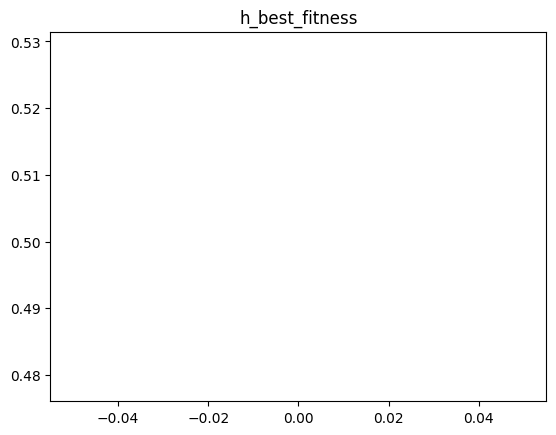

In [9]:

datos = misDatos()

best_global_individual, best_global_fitness, h_pop, h_parents_pop, h_best_pop, new_pop,  h_layers, h_params = evo_get_model(
  datos.X_train, datos.Y_train,
  pop = create_model().crear_population(2),
  n_generations = 1,
  n_epochs = 1 ,
  n_best_pop = 1,
  n_parents = 2,
  n_chance_flip_crossover = 0.5,
  n_chance_flip_mutation = 0.5,
  n_immigration_population = 2,
  n_callback_patience = 10
  )


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 INPUT (InputLayer)             [(None, 12)]         0           []                               
                                                                                                  
 Densa_0 (Dense)                (None, 4)            52          ['INPUT[0][0]']                  
                                                                                                  
 dropout_28 (Dropout)           (None, 4)            0           ['Densa_0[0][0]']                
                                                                                                  
 Densa_1 (Dense)                (None, 3)            15          ['dropout_28[0][0]']             
                                                                                            

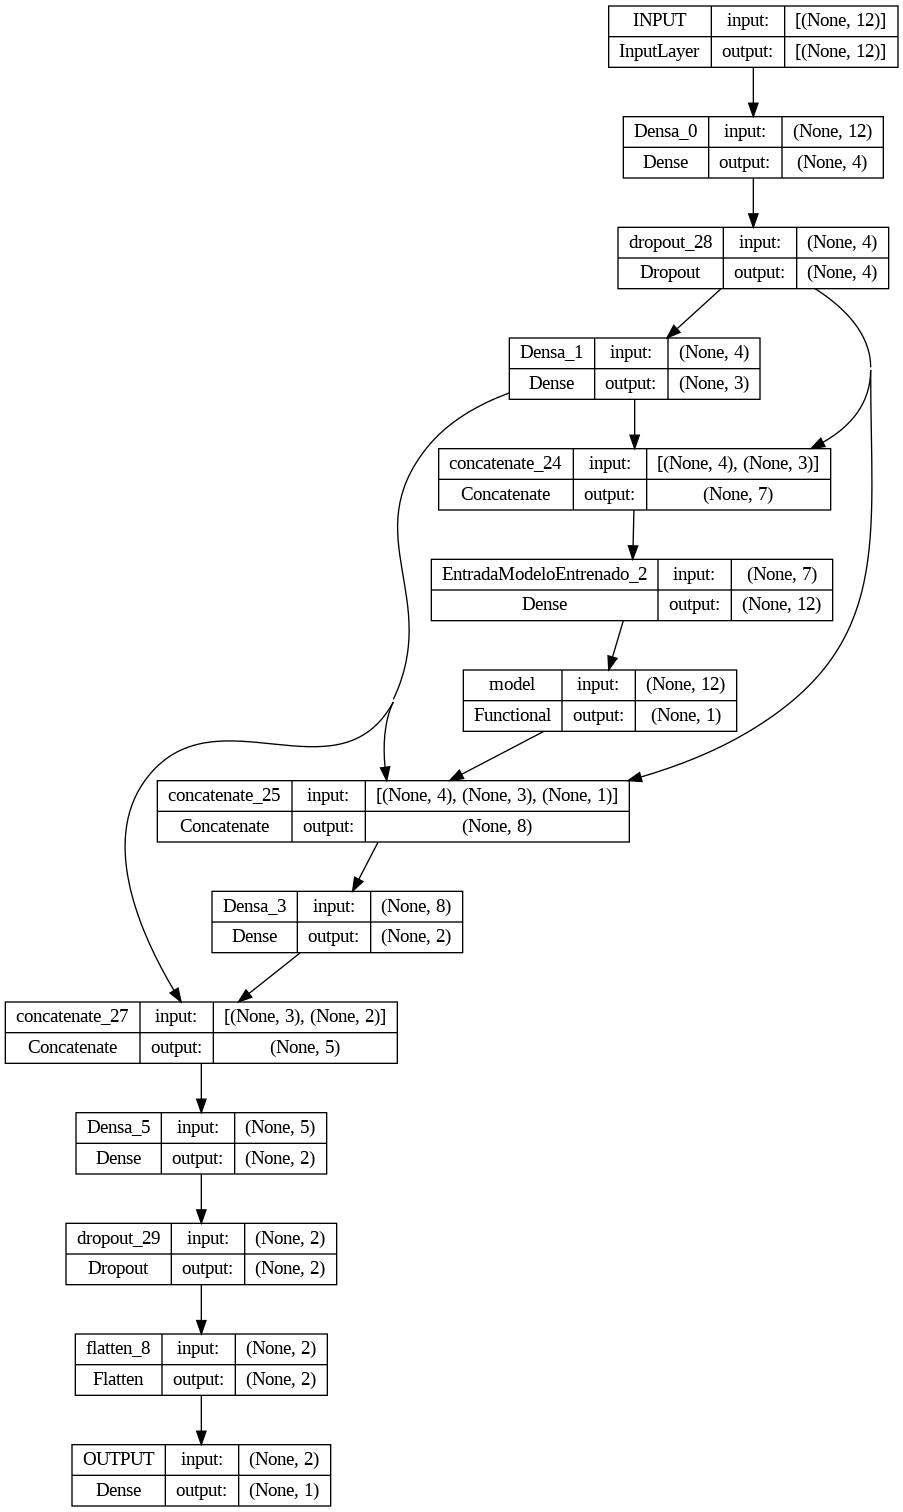

In [10]:
_ = create_model()
model_a = _.create_model(
    best_global_individual,
    datos.X_train.shape[1:],
    1)
model_a.summary()
plot_model(model_a, show_shapes=True, show_layer_names=True)

# MODELO FIJO VS MODELO EVOLUTIVO  

In [11]:
datos = misDatos()

In [12]:
list(sorted(set(datos.df_train.date)))[0], list(sorted(set(datos.df_train.date)))[-1]

(Timestamp('1993-09-27 00:00:00'), Timestamp('2020-12-31 00:00:00'))

In [13]:
list(sorted(set(datos.df_test.date)))[0], list(sorted(set(datos.df_test.date)))[-1]

(Timestamp('2021-01-04 00:00:00'), Timestamp('2023-08-10 00:00:00'))

## mascara_1 (def)

In [14]:
def mascara_1(n_activos, array = [2,0,0,0,0.3,0,0,0,-1.3,0,0,0] ):

  mask = np.array(array)
  # Extender la máscara para que tenga la misma forma que data
  full_mask = np.tile(mask, (n_activos, 1))

  return full_mask

## get_accuracy (def)

In [15]:
def get_accuracy(x, y_true, model):
  y_pred = model(x)
  y_pred = y_pred.numpy().round(2).reshape(-1)
  y_pred_labels = (y_pred >= 0.5).astype(int)

  # Accuracy modelo fijo datos reales
  accuracy = np.mean(y_true == y_pred_labels)

  return accuracy


## get_datos(def)

In [16]:
def get_datos(datos_dia, mask_vs):
  # datos dia
  #datos_dia = data_vs[data_vs.date == str(day.date())]
  #print("Fechas:" , str(list(sorted(set(datos_dia.date)))[-1].date()) + " - " + str(list(sorted(set(datos_dia.date)))[0].date())  )
  indices_seleccionados = datos_dia.index

  y_true = np.array( datos_dia.iloc[:,-1] )
  x = datos_dia.iloc[:,2:-1]
  x = np.array(x)

  # Datos manipulados
  mascara_del_dia = mask_vs.loc[indices_seleccionados]
  mascara_del_dia = np.array(mascara_del_dia)

  x_manipulados = x * mascara_del_dia
  x_manipulados = np.array(x_manipulados)

  return x, x_manipulados, y_true

## entrenar_modelo (def)

In [17]:
def entrenar_modelo(x, y_true,model ):

  earlystopping = EarlyStopping(
  monitor='val_accuracy',
  patience=50,
  restore_best_weights=True,
  verbose = True
  )

  model.fit(
        x, y_true,
        epochs=500,
        batch_size = x.shape[0],
        validation_split = 0.3,
        callbacks = [earlystopping],
        shuffle=True,
        verbose=False
        )

## Ejecutamos VS

In [ ]:
data_vs = datos.df_test.copy()
data_vs.iloc[:, 2:14] = datos.scaler.transform(data_vs.iloc[:, 2:14])

mascara = mascara_1
# Dado que las mascaras son aleatorias crearemos una mascara para todo el dataset fija
mask_vs = mascara(data_vs.shape[0])
mask_vs = pd.DataFrame(mask_vs, index = data_vs.index)

# Modelos vs
model_fijo_datos_reales = load_model('best_model_0.h5')
model_fijo = load_model('best_model_0.h5')
model_evolutivo = load_model('best_model_0.h5')

# Entrenaremos cada x dias
contador_entrenamiento = 0
dias_para_entrenar = 400

# Contaremos el numero de vaces que el val_acurracy fue inferior a un nivel de referencia
contador_fallos_evolutivo = 0
nivel_de_referencia = 0.75
n_fallos_posibles = 15

h_accuracy_fijo_datos_reales = []
h_accuracy_fijo = []
h_acurracy_evolutivo = []
h_dia_entrenado = []
h_dia_evolucion = []
h_contador_fallos = []


fechas_para_iterar = sorted(set(data_vs.date))
for day in fechas_para_iterar:


  h_dia_entrenado.append(0)
  h_dia_evolucion.append(0)

  # datos dia
  datos_dia = data_vs[data_vs.date == str(day.date())]
  x, x_manipulados, y_true = get_datos(datos_dia, mask_vs)

  # ------ Preds & Acc ------

  # - Pred modelo fijo datos reales -

  h_accuracy_fijo_datos_reales.append(    get_accuracy(x, y_true, model_fijo_datos_reales)  )

  #  -Pred modelo fijo -

  h_accuracy_fijo.append(                   get_accuracy(x_manipulados, y_true, model_fijo)  )

  #  -Pred modelo evolutivo -

  h_acurracy_evolutivo.append(                get_accuracy(x_manipulados, y_true, model_evolutivo)  )

  # Contador fallos evolutivo

  contador_fallos_evolutivo += ( h_acurracy_evolutivo[-1] < nivel_de_referencia ) * 1
  h_contador_fallos.append(contador_fallos_evolutivo)


  # ------ ENTRENAMIENTO ------

  contador_entrenamiento += 1
  if contador_entrenamiento >= dias_para_entrenar :
    contador_entrenamiento = 0
    h_dia_entrenado[-1] = 1

    # datos entrenamiento
    datos_dia = data_vs[data_vs.date < str(day.date())]
    print("Fechas Train:" , str(list(sorted(set(datos_dia.date)))[-1].date()) + " - " + str(list(sorted(set(datos_dia.date)))[0].date())  )

    print("Fallos:", contador_fallos_evolutivo )
    x, x_manipulados, y_true = get_datos(datos_dia, mask_vs)
    print("shape entrenamiento: " , x.shape)
    # Entrenamos modelo fijo datos reales
    print("Entrenamos Fijo datos reales")
    entrenar_modelo(x, y_true, model_fijo_datos_reales )

    # Entrenamos modelo fijo
    print("Entrenamos Fijo")
    entrenar_modelo(x_manipulados, y_true, model_fijo )

    # ¿ Evolucinamos ?
    if contador_fallos_evolutivo > n_fallos_posibles:

      print("EVOLUCION")
      contador_fallos_evolutivo = 0
      h_dia_evolucion[-1] = 1
      model_evolutivo = proceso_evolucion(x_manipulados, y_true)

    else:
      # Entrenamos modelo evolutivo
      print("Entrenamos Evolutivo")
      entrenar_modelo(x_manipulados, y_true, model_evolutivo )

print("FIN")


Fechas Train: 2022-07-22 - 2021-01-04
Fallos: 400
shape entrenamiento:  (13824, 12)
Entrenamos Fijo datos reales
Restoring model weights from the end of the best epoch: 208.
Epoch 258: early stopping
Entrenamos Fijo
Restoring model weights from the end of the best epoch: 55.
Epoch 105: early stopping
EVOLUCION
Proceso Evolucion _ 0
-------------------------------
[[0.  1.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.  1.  1.  4.  1.
  1.  1.  5.  0.3 0.3 0.9 0.  0.9 0.  0.  0.6 0.  0.9 0.3 0.  2. ]
 [1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  2.  3.  5.
  4.  5.  2.  0.3 0.9 0.6 0.9 0.  0.9 0.  0.9 0.6 0.  0.3 0.3 5. ]
 [1.  1.  1.  1.  1.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  2.  5.  2.
  4.  1.  5.  0.  0.  0.  0.6 0.6 0.9 0.3 0.6 0.6 0.3 0.6 0.  4. ]
 [0.  0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.  0.  1.  5.  4.  5.
  4.  5.  5.  0.  0.3 0.9 0.  0.9 0.3 0.  0.6 0.3 0.6 0.9 0.9 1. ]
 [1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  3.  3.  1.
 

In [ ]:
model_evolutivo.save('best_model_vs_0.h5')

In [ ]:
model_evolutivo.summary()
plot_model(model_evolutivo, show_shapes=True, show_layer_names=True)

In [ ]:
fig, ax = plt.subplots(figsize=(30,5))
plt.plot(model_fijo(datos.X_test), marker='o', linestyle='none')

In [ ]:
fig, ax = plt.subplots(figsize=(30,5))
plt.plot(model_evolutivo(datos.X_test), marker='o', linestyle='none')

### ver_performance (def)

In [ ]:
def ver_performance(h_acurracy_evolutivo ):
  # Tu array de valores
  data = np.array(h_acurracy_evolutivo)
  # Calcula la suma acumulativa
  cumulative_sum = np.cumsum(data)
  # Calcula la media acumulativa
  cumulative_average = cumulative_sum / (np.arange(len(data)) + 1)


  fig, ax = plt.subplots(figsize=(30,5))

  plt.plot( h_acurracy_evolutivo,  color='red',  label='h_acurracyo', marker='o', linestyle='none')

  plt.plot( cumulative_average ,  color='red')


  # Trazar líneas verticales azules donde h_dia_entrenado sea 1
  for i, value in enumerate(h_dia_entrenado):
      if value == 1:
          ax.axvline(x=i, color='blue', linestyle='--', alpha=0.7)
  # Trazar líneas verticales azules donde h_dia_evolucion sea 1
  for i, value in enumerate(h_dia_evolucion):
      if value == 1:
          ax.axvline(x=i, color='red', linestyle='--', alpha=0.7)


  ax.set_xlabel("dia")
  ax.set_ylabel("Binary cross entropy")

  plt.show()

### Ver resultados

In [ ]:
 # Tu array de valores
data = np.array(h_accuracy_fijo)
# Calcula la suma acumulativa
cumulative_sum = np.cumsum(data)
# Calcula la media acumulativa
cumulative_average = cumulative_sum / (np.arange(len(data)) + 1)


fig, ax = plt.subplots(figsize=(30,5))

plt.plot( cumulative_average,  color='red')

 # Tu array de valores
data = np.array(h_acurracy_evolutivo)
# Calcula la suma acumulativa
cumulative_sum = np.cumsum(data)
# Calcula la media acumulativa
cumulative_average = cumulative_sum / (np.arange(len(data)) + 1)


plt.plot( cumulative_average,  color='blue')


In [ ]:
ver_performance(h_accuracy_fijo)
ver_performance(h_acurracy_evolutivo )
ver_performance(h_accuracy_fijo_datos_reales )

In [ ]:
# Tu array de valores
data = np.array(h_accuracy_fijo)
# Calcula la suma acumulativa
cumulative_sum = np.cumsum(data)
# Calcula la media acumulativa
cumulative_average = cumulative_sum / (np.arange(len(data)) + 1)

fig, ax = plt.subplots(figsize=(30,5))

plt.plot( h_accuracy_fijo,  color='red',  label='h_acurracyo', marker='o', linestyle='none')

plt.plot( cumulative_average ,  color='red')


# Tu array de valores
data = np.array(h_acurracy_evolutivo)
# Calcula la suma acumulativa
cumulative_sum = np.cumsum(data)
# Calcula la media acumulativa
cumulative_average = cumulative_sum / (np.arange(len(data)) + 1)



plt.plot( h_acurracy_evolutivo,  color='blue',  label='h_acurracyo', marker='o', linestyle='none')

plt.plot( cumulative_average ,  color='blue')




# Trazar líneas verticales azules donde h_dia_entrenado sea 1
for i, value in enumerate(h_dia_entrenado):
    if value == 1:
        ax.axvline(x=i, color='blue', linestyle='--', alpha=0.7)
# Trazar líneas verticales azules donde h_dia_evolucion sea 1
for i, value in enumerate(h_dia_evolucion):
    if value == 1:
        ax.axvline(x=i, color='red', linestyle='--', alpha=0.7)


ax.set_xlabel("dia")
ax.set_ylabel("Binary cross entropy")

plt.show()

Despues de probar la 4 no parece, empeorar demasiado, al tener tener features aleatorias parece ser capaz de extraer informacion, añadiendo ese conocimiento al que adquirio al entrenarse con datos anteriores.

Es mas, funciono mejor con los datos manipulados. Esa mascara funciona como un dropout, es posible que la red aprendiera a generalizar mejor.

TODO: dejar todo en clases limpipo sobre tdo los dataset, y probar a pone run layer en evo el modelo conglado